In [88]:
import qiskit
from qiskit.circuit import QuantumCircuit
from qiskit.algorithms.optimizers import SPSA
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [118]:
EPOCHS = 500
SEED = 16
P = 0.25

In [90]:
def PoolingCirc(qc, weights, wires):
    qc.cry(weights[0], wires[0], wires[1])
    qc.x(wires[0])
    qc.cry(weights[1], wires[0], wires[1])
    qc.x(wires[0])

def ConvCirc1(qc, weights, wires):
    qc.ry(weights[0], wires[0])
    qc.ry(weights[1], wires[1])
    qc.cnot(wires[0], wires[1])

In [91]:
inputs = ['+X','-X','+Y','-Y','+Z','-Z']

def circuit(qc, params, data):

    if data not in inputs:
        raise ValueError('Invalid Input')

    # Data encoding
    if data == '+X':
        qc.h(0)
    elif data == '-X':
        qc.x(0)
        qc.h(0)
    elif data == '+Y':
        qc.rx(-np.pi/2, 0)
    elif data == '-Y':
        qc.rx(np.pi/2, 0)
    elif data == '-Z':
        qc.x(0)

    # Shor Encoding
    qc.cnot(0,1)
    qc.cnot(0,2)

    #Error Generating
    qc.barrier()
    for i in range(2):
        qc.cnot(i, i+1)
    qc.barrier()
    qc.cnot(1, 2)
    qc.cnot(0, 1)
    qc.barrier()

    #QCNN
    ConvCirc1(qc, params[0:2], wires = [0, 1])  
    ConvCirc1(qc, params[2:4], wires = [2, 3])    
    ConvCirc1(qc, params[4:6], wires = [1, 2])
    ConvCirc1(qc, params[6:8], wires = [3, 0])
    qc.barrier()
    PoolingCirc(qc, params[8:10], wires = [0, 1])
    PoolingCirc(qc, params[10:12], wires = [2, 3])
    qc.barrier()
    ConvCirc1(qc, params[12:14], wires = [1, 3])
    qc.barrier()
    PoolingCirc(qc, params[14:16], wires = [1, 3])
    qc.barrier()

    #adjoint
    if data == '+X':
        qc.h(3)
    elif data == '-X':
        qc.x(3)
        qc.h(3)
    elif data == '+Y':
        qc.rx(+np.pi/2, 3)
    elif data == '-Y':
        qc.rx(-np.pi/2, 3)
    elif data == '-Z':
        qc.x(3)

    qc.measure(3, 0)

    return qc

In [92]:
qc = QuantumCircuit(4, 1)
pv = qiskit.circuit.ParameterVector('x', 16)
qc = circuit(qc, pv, inputs[0])
qc.draw()

┌───┐           ░            ░            ░ ┌──────────┐     ┌──────────┐»
q_0: ┤ H ├──■────■───░───■────────░────────■───░─┤ Ry(x[0]) ├──■──┤ Ry(x[7]) ├»
     └───┘┌─┴─┐  │   ░ ┌─┴─┐      ░      ┌─┴─┐ ░ ├──────────┤┌─┴─┐├──────────┤»
q_1: ─────┤ X ├──┼───░─┤ X ├──■───░───■──┤ X ├─░─┤ Ry(x[1]) ├┤ X ├┤ Ry(x[4]) ├»
          └───┘┌─┴─┐ ░ └───┘┌─┴─┐ ░ ┌─┴─┐└───┘ ░ ├──────────┤└───┘├──────────┤»
q_2: ──────────┤ X ├─░──────┤ X ├─░─┤ X ├──────░─┤ Ry(x[2]) ├──■──┤ Ry(x[5]) ├»
               └───┘ ░      └───┘ ░ └───┘      ░ ├──────────┤┌─┴─┐├──────────┤»
q_3: ────────────────░────────────░────────────░─┤ Ry(x[3]) ├┤ X ├┤ Ry(x[6]) ├»
                     ░            ░            ░ └──────────┘└───┘└──────────┘»
c: 1/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«          ┌───┐ ░              ┌───┐             ┌───┐ ░                    ░ »
«q_0: ─────┤ X ├─░───────■──────┤ X ├──────■──────┤ X ├─░────────────────────░─»
«          └─┬─┘ ░  ┌────┴─────┐└───┘ ┌────┴─────┐└───┘ ░ ┌───────────┐      ░ »
«q_1: ──■────┼───░──┤ Ry(x[8]) ├──────┤ Ry(x[9]) ├──────░─┤ Ry(x[12]) ├──■───░─»
«     ┌─┴─┐  │   ░  └──────────┘┌───┐ └──────────┘┌───┐ ░ └───────────┘  │   ░ »
«q_2: ┤ X ├──┼───░───────■──────┤ X ├──────■──────┤ X ├─░────────────────┼───░─»
«     └───┘  │   ░ ┌─────┴─────┐└───┘┌─────┴─────┐└───┘ ░ ┌───────────┐┌─┴─┐ ░ »
«q_3: ───────■───░─┤ Ry(x[10]) ├─────┤ Ry(x[11]) ├──────░─┤ Ry(x[13]) ├┤ X ├─░─»
«                ░ └───────────┘     └───────────┘      ░ └───────────┘└───┘ ░ »
«c: 1/═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«                                          ░         
«q_0: ─────────────────────────────────────░─────────
«                  ┌───┐             ┌───┐ ░         
«q_1: ──────■──────┤ X ├──────■──────┤ X ├─░─────────
«           │      └───┘      │      └───┘ ░         
«q_2: ──────┼─────────────────┼────────────░─────────
«     ┌─────┴─────┐     ┌─────┴─────┐      ░ ┌───┐┌─┐
«q_3: ┤ Ry(x[14]) ├─────┤ Ry(x[15]) ├──────░─┤ H ├┤M├
«     └───────────┘     └───────────┘      ░ └───┘└╥┘
«c: 1/═════════════════════════════════════════════╩═
«                                                  0

In [93]:
from qiskit.test.mock import FakeVigo
device_backend = FakeVigo()
sim_vigo = AerSimulator.from_backend(device_backend)

In [94]:
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.providers.aer import AerSimulator
from tqdm import tqdm

#quantum_instance = QuantumInstance(backend=AerSimulator(), shots=1024, optimization_level=0)
quantum_instance = QuantumInstance(backend=sim_vigo, shots=1024, optimization_level=0)

def cost(params):
    ret = 0
    for input in inputs:
        qc = QuantumCircuit(4, 1)
        qc = circuit(qc, params, input)
        ret_dict = quantum_instance.execute(qc).get_counts()
        ret += -ret_dict['0']/sum(list(ret_dict.values()))
    return ret/len(inputs)
cost_list = []
def callback(*args):
    cost_list.append(args[2])
    print('{} Iter | Cost {}'.format(int(args[0]/3), args[2]))

optim = SPSA(maxiter = 100, blocking = True, callback=callback)

result = optim.minimize(cost, np.random.rand(16))


1 Iter | Cost -0.4208984375
2 Iter | Cost -0.4812825520833333
3 Iter | Cost -0.50537109375
4 Iter | Cost -0.5115559895833334
5 Iter | Cost -0.5118815104166666
6 Iter | Cost -0.5177408854166666
7 Iter | Cost -0.5276692708333334
8 Iter | Cost -0.5802408854166666
9 Iter | Cost -0.58740234375
10 Iter | Cost -0.5647786458333334
11 Iter | Cost -0.5712890625
12 Iter | Cost -0.5895182291666666
13 Iter | Cost -0.5751953125
14 Iter | Cost -0.5859375
15 Iter | Cost -0.580078125
16 Iter | Cost -0.5638020833333334
17 Iter | Cost -0.5690104166666666
18 Iter | Cost -0.5851236979166666
19 Iter | Cost -0.6092122395833334
20 Iter | Cost -0.6136067708333334
21 Iter | Cost -0.62744140625
22 Iter | Cost -0.6271158854166666
23 Iter | Cost -0.6276041666666666
24 Iter | Cost -0.6321614583333334
25 Iter | Cost -0.6134440104166666
26 Iter | Cost -0.6199544270833334
27 Iter | Cost -0.6521809895833334
28 Iter | Cost -0.6736653645833334
29 Iter | Cost -0.6512044270833334
30 Iter | Cost -0.66259765625
31 Iter | Cos

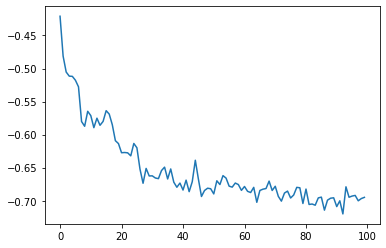

In [95]:
from matplotlib import pyplot as plt 
plt.plot(cost_list)

In [96]:
print(result)

{   'fun': -0.6907552083333334,
    'jac': None,
    'nfev': 301,
    'nit': None,
    'njev': None,
    'x': array([ 0.33571971,  0.60865522,  0.13641891, -0.04772747, -1.41821582,
        0.01111714,  0.01993577,  0.26632005,  0.34347089, -0.32347818,
        0.15734961,  1.29698338,  1.23047361,  1.07406778, -0.9707693 ,
       -1.57558421])}


In [97]:
def shor_circuit(qc, data):

    if data not in inputs:
        raise ValueError('Invalid Input')

    # Data encoding
    if data == '+X':
        qc.h(0)
    elif data == '-X':
        qc.x(0)
        qc.h(0)
    elif data == '+Y':
        qc.rx(-np.pi/2, 0)
    elif data == '-Y':
        qc.rx(np.pi/2, 0)
    elif data == '-Z':
        qc.x(0)

    # Shor Encoding
    qc.cnot(0,1)
    qc.cnot(0,2)

    #Error Generating
    #Error Generating
    qc.barrier()
    for i in range(2):
        qc.cnot(i, i+1)
    qc.barrier()
    qc.cnot(1, 2)
    qc.cnot(0, 1)
    qc.barrier()

    #Shor Decoder
    qc.cnot(0, 1)
    qc.cnot(0, 2)
    qc.toffoli(2, 1, 0)

    #adjoint
    if data == '+X':
        qc.h(0)
    elif data == '-X':
        qc.x(0)
        qc.h(0)
    elif data == '+Y':
        qc.rx(+np.pi/2, 0)
    elif data == '-Y':
        qc.rx(-np.pi/2, 0)
    elif data == '-Z':
        qc.x(0)

    qc.measure(0, 0)

    return qc

In [98]:
quantum_instance = QuantumInstance(backend=sim_vigo, shots=1024, optimization_level=0)

def shor_cost():
    ret = 0
    for input in inputs:
        qc = QuantumCircuit(4, 1)
        qc = shor_circuit(qc, input)
        ret_dict = quantum_instance.execute(qc).get_counts()
        ret += -ret_dict['0']/sum(list(ret_dict.values()))
    return ret/len(inputs)

In [99]:
shor_cost()

-0.7639973958333334

In [100]:
test = QuantumCircuit(4)
dperror = qiskit.providers.aer.noise.depolarizing_error(param = 0.24, num_qubits = 4, standard_gates=None)
dperror = dperror.to_instruction()
for i in range(4):
    test.h(i)
test = test.compose(dperror)
test.draw()

┌───┐┌──────────────────┐
q_0: ┤ H ├┤0                 ├
     ├───┤│                  │
q_1: ┤ H ├┤1                 ├
     ├───┤│  Quantum_channel │
q_2: ┤ H ├┤2                 ├
     ├───┤│                  │
q_3: ┤ H ├┤3                 ├
     └───┘└──────────────────┘

In [111]:
def error_channel_circuit(qc, params, data, p):

    if data not in inputs:
        raise ValueError('Invalid Input')

    # Data encoding
    if data == '+X':
        qc.h(0)
    elif data == '-X':
        qc.x(0)
        qc.h(0)
    elif data == '+Y':
        qc.rx(-np.pi/2, 0)
    elif data == '-Y':
        qc.rx(np.pi/2, 0)
    elif data == '-Z':
        qc.x(0)

    # Shor Encoding
    qc.cnot(0,1)
    qc.cnot(0,2)

    #Error Generating
    dperror = qiskit.providers.aer.noise.depolarizing_error(param = p, num_qubits = 3, standard_gates=None)
    dperror = dperror.to_instruction()
    qc = qc.compose(dperror)

    #QCNN
    ConvCirc1(qc, params[0:2], wires = [0, 1])  
    ConvCirc1(qc, params[2:4], wires = [2, 3])    
    ConvCirc1(qc, params[4:6], wires = [1, 2])
    ConvCirc1(qc, params[6:8], wires = [3, 0])
    qc.barrier()
    PoolingCirc(qc, params[8:10], wires = [0, 1])
    PoolingCirc(qc, params[10:12], wires = [2, 3])
    qc.barrier()
    ConvCirc1(qc, params[12:14], wires = [1, 3])
    qc.barrier()
    PoolingCirc(qc, params[14:16], wires = [1, 3])
    qc.barrier()

    #adjoint
    if data == '+X':
        qc.h(3)
    elif data == '-X':
        qc.x(3)
        qc.h(3)
    elif data == '+Y':
        qc.rx(+np.pi/2, 3)
    elif data == '-Y':
        qc.rx(-np.pi/2, 3)
    elif data == '-Z':
        qc.x(3)

    qc.measure(3, 0)

    return qc

In [128]:
quantum_instance = QuantumInstance(backend=AerSimulator(), shots=1024, optimization_level=0)

def error_channel_cost(params):
    ret = 0
    for input in inputs:
        qc = QuantumCircuit(4, 1)
        qc = error_channel_circuit(qc, params, input, p = 0.01)
        ret_dict = quantum_instance.execute(qc).get_counts()
        ret += -ret_dict['0']/sum(list(ret_dict.values()))
    return ret/len(inputs)
cost_list = []
def callback(*args):
    cost_list.append(args[2])
    print('{} Iter | Cost {}'.format(int(args[0]/3), args[2]))

optim = SPSA(maxiter = 500, blocking = True, callback=callback)

result = optim.minimize(cost, np.random.rand(16))

1 Iter | Cost -0.3370768229166667
2 Iter | Cost -0.552734375
3 Iter | Cost -0.54248046875
4 Iter | Cost -0.66064453125
5 Iter | Cost -0.6678059895833334
6 Iter | Cost -0.6778971354166666
7 Iter | Cost -0.681640625
8 Iter | Cost -0.69091796875
9 Iter | Cost -0.6975911458333334
10 Iter | Cost -0.6920572916666666
11 Iter | Cost -0.6505533854166666
12 Iter | Cost -0.68017578125
13 Iter | Cost -0.6951497395833334
14 Iter | Cost -0.7023111979166666
15 Iter | Cost -0.7054036458333334
16 Iter | Cost -0.6959635416666666
17 Iter | Cost -0.7303059895833334
18 Iter | Cost -0.7351888020833334
19 Iter | Cost -0.7314453125
20 Iter | Cost -0.7399088541666666
21 Iter | Cost -0.7379557291666666
22 Iter | Cost -0.74853515625
23 Iter | Cost -0.73583984375
24 Iter | Cost -0.7447916666666666
25 Iter | Cost -0.7542317708333334
26 Iter | Cost -0.751953125
27 Iter | Cost -0.7560221354166666
28 Iter | Cost -0.7529296875
29 Iter | Cost -0.75390625
30 Iter | Cost -0.7565104166666666
31 Iter | Cost -0.76611328125


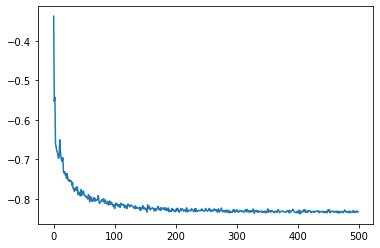

In [129]:
plt.plot(cost_list)

In [130]:
min(cost_list)

-0.8385416666666666

In [124]:
qc = QuantumCircuit(4, 1)
qc = error_channel_circuit(qc, np.zeros(16), '+X', p = 0.01)
quantum_instance.transpile(qc)[0].draw()

┌───┐            ┌──────────────────┐┌───────┐     ┌───────┐     ┌───┐»
q_0: ──┤ H ├────■────■──┤0                 ├┤ Ry(0) ├──■──┤ Ry(0) ├─────┤ X ├»
       └───┘  ┌─┴─┐  │  │                  │├───────┤┌─┴─┐├───────┤     └─┬─┘»
q_1: ─────────┤ X ├──┼──┤1 Quantum_channel ├┤ Ry(0) ├┤ X ├┤ Ry(0) ├──■────┼──»
              └───┘┌─┴─┐│                  │├───────┤└───┘├───────┤┌─┴─┐  │  »
q_2: ──────────────┤ X ├┤2                 ├┤ Ry(0) ├──■──┤ Ry(0) ├┤ X ├──┼──»
     ┌───────┐     └───┘└──────────────────┘└───────┘┌─┴─┐├───────┤└───┘  │  »
q_3: ┤ Ry(0) ├───────────────────────────────────────┤ X ├┤ Ry(0) ├───────■──»
     └───────┘                                       └───┘└───────┘          »
c: 1/════════════════════════════════════════════════════════════════════════»
                                                                             »
«      ░                                    ┌───┐                        ┌───┐»
«q_0: ─░──────────────■───────────────■─────┤ X ├─────■───────────────■──┤ X ├»
«      ░ ┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐┌──┴───┴──┐┌─┴─┐┌─────────┐┌─┴─┐└───┘»
«q_1: ─░─┤ Ry(0.0) ├┤ X ├┤ Ry(0.0) ├┤ X ├┤ Ry(0.0) ├┤ X ├┤ Ry(0.0) ├┤ X ├─────»
«      ░ └─────────┘└───┘└─────────┘└───┘└──┬───┬──┘└───┘└─────────┘└───┘┌───┐»
«q_2: ─░──────────────■───────────────■─────┤ X ├─────■───────────────■──┤ X ├»
«      ░ ┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐┌──┴───┴──┐┌─┴─┐┌─────────┐┌─┴─┐└───┘»
«q_3: ─░─┤ Ry(0.0) ├┤ X ├┤ Ry(0.0) ├┤ X ├┤ Ry(0.0) ├┤ X ├┤ Ry(0.0) ├┤ X ├─────»
«      ░ └─────────┘└───┘└─────────┘└───┘└─────────┘└───┘└─────────┘└───┘     »
«c: 1/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«      ░                ░                                                 »
«q_0: ─░────────────────░─────────────────────────────────────────────────»
«      ░ ┌───────┐      ░                                    ┌───┐        »
«q_1: ─░─┤ Ry(0) ├──■───░──────────────■───────────────■─────┤ X ├─────■──»
«      ░ └───────┘  │   ░              │               │     └───┘     │  »
«q_2: ─░────────────┼───░──────────────┼───────────────┼───────────────┼──»
«      ░ ┌───────┐┌─┴─┐ ░ ┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐»
«q_3: ─░─┤ Ry(0) ├┤ X ├─░─┤ Ry(0.0) ├┤ X ├┤ Ry(0.0) ├┤ X ├┤ Ry(0.0) ├┤ X ├»
«      ░ └───────┘└───┘ ░ └─────────┘└───┘└─────────┘└───┘└─────────┘└───┘»
«c: 1/════════════════════════════════════════════════════════════════════»
«                                                                         »
«                           ░         
«q_0: ──────────────────────░─────────
«                     ┌───┐ ░         
«q_1: ─────────────■──┤ X ├─░─────────
«                  │  └───┘ ░         
«q_2: ─────────────┼────────░─────────
«     ┌─────────┐┌─┴─┐      ░ ┌───┐┌─┐
«q_3: ┤ Ry(0.0) ├┤ X ├──────░─┤ H ├┤M├
«     └─────────┘└───┘      ░ └───┘└╥┘
«c: 1/══════════════════════════════╩═
«                                   0

In [125]:
def shor_error_channel_circuit(qc, data, p):

    if data not in inputs:
        raise ValueError('Invalid Input')

    # Data encoding
    if data == '+X':
        qc.h(0)
    elif data == '-X':
        qc.x(0)
        qc.h(0)
    elif data == '+Y':
        qc.rx(-np.pi/2, 0)
    elif data == '-Y':
        qc.rx(np.pi/2, 0)
    elif data == '-Z':
        qc.x(0)

    # Shor Encoding
    qc.cnot(0,1)
    qc.cnot(0,2)

    #Error Generating
    dperror = qiskit.providers.aer.noise.depolarizing_error(param = p, num_qubits = 3, standard_gates=None)
    dperror = dperror.to_instruction()
    qc = qc.compose(dperror)

    #Shor Decoder
    qc.cnot(0, 1)
    qc.cnot(0, 2)
    qc.toffoli(2, 1, 0)

    #adjoint
    if data == '+X':
        qc.h(0)
    elif data == '-X':
        qc.x(0)
        qc.h(0)
    elif data == '+Y':
        qc.rx(+np.pi/2, 0)
    elif data == '-Y':
        qc.rx(-np.pi/2, 0)
    elif data == '-Z':
        qc.x(0)

    qc.measure(0, 0)

    return qc

In [126]:
qc = QuantumCircuit(4, 1)
qc = shor_error_channel_circuit(qc, '+X', p = 0.01)
quantum_instance.transpile(qc)[0].draw()

┌───┐          ┌──────────────────┐          ┌───┐┌───┐┌─┐
q_0: ┤ H ├──■────■──┤0                 ├──■────■──┤ X ├┤ H ├┤M├
     └───┘┌─┴─┐  │  │                  │┌─┴─┐  │  └─┬─┘└───┘└╥┘
q_1: ─────┤ X ├──┼──┤1 Quantum_channel ├┤ X ├──┼────■────────╫─
          └───┘┌─┴─┐│                  │└───┘┌─┴─┐  │        ║ 
q_2: ──────────┤ X ├┤2                 ├─────┤ X ├──■────────╫─
               └───┘└──────────────────┘     └───┘           ║ 
q_3: ────────────────────────────────────────────────────────╫─
                                                             ║ 
c: 1/════════════════════════════════════════════════════════╩═
                                                             0

In [127]:
quantum_instance = QuantumInstance(backend=AerSimulator(), shots=1024, optimization_level=0)

def shor_cost():
    ret = 0
    for input in inputs:
        qc = QuantumCircuit(4, 1)
        qc = shor_error_channel_circuit(qc, input, p = 0.01)
        ret_dict = quantum_instance.execute(qc).get_counts()
        ret += -ret_dict['0']/sum(list(ret_dict.values()))
    return ret/len(inputs)

print(shor_cost())

-0.8284505208333334
